# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [49]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [50]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [51]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.40446903790544014
RMSE when predicting testing data:
1.0666204347667474
RMSE with random predictions:
5.262103337484077


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [52]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

,estimator,RandomForestRegressor()
,param_grid,"{'max_depth': [2, 4, ...], 'n_estimators': [10, 33, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [53]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851467026495314


In [54]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12289873, -1.09373797, -1.0851467 ])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [55]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

In [56]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

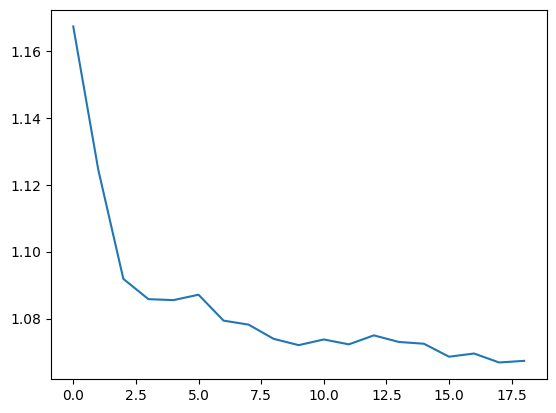

In [57]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

This curve plots the model's performance on the test set as a function of increasing training set size. The error is very large at first since the model starts with very little data from which to learn. As more and more of the data is used to train the model, the error typically decreases. At some point, the curve begins to flatten, meaning that additional data provides a smaller return in performance. This demonstrates the advantage of having more data, and provides a visualization of the random forest's learning curve.

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [58]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.

### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

# Generate data for alpha = 0
X0, y0 = make_X_y(alpha=0)
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.3)
rf0 = RandomForestRegressor()
rf0.fit(X0_train, y0_train)
y0_pred = rf0.predict(X0_test)
corr0, _ = pearsonr(y0_test, y0_pred)

# Generate data for alpha = 10
X10, y10 = make_X_y(alpha=10)
X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10, test_size=0.3)
rf10 = RandomForestRegressor()
rf10.fit(X10_train, y10_train)
y10_pred = rf10.predict(X10_test)
corr10, _ = pearsonr(y10_test, y10_pred)

print("Correlation with alpha=0:", corr0)
print("Correlation with alpha=10:", corr10)


Correlation with alpha=0: -0.004328302729536252
Correlation with alpha=10: 0.9930775117840439


I ran the following code. In contrast to the previous runs, the correlation between predictions and true values was dramatically higher when alpha=10 than when alpha=0. This result suggests that when the target stock shares some structure in common with the others, the model can learn some informative relations. If no shared signal exists (alpha = 0), then the model can not do better than guessing. I found this experiment to be very illustrative of the impact of signal strength and noise on predictive modeling.

In [60]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distributions
param_dist = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [2, 4, 6, 8, None],
    "min_samples_split": [2, 5, 10]
}

# Create the RandomizedSearchCV object
rsearch = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=0
)

# Fit the model
rsearch.fit(train_df.values, train_target)

# View results
print("Best parameters:", rsearch.best_params_)
print("Best RMSE (negated):", rsearch.best_score_)


Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}
Best RMSE (negated): -1.0621169548092766


I substituted the GridSearchCV with the RandomizedSearchCV to decrease the computational expense. It draws samples from a distribution of parameter combinations, and tests a fixed number of parameter settings sampled randomly. So instead of trying all the combinations, it tests 10 random combinations of the parameters. This is useful when you're tuning a lot of hyperparameters, or when training time is very long. The results showed that I can find a high-performing model with just a few iterations. I understand that RandomizedSearch is a technique that I can use when I need quicker or more scalable hyperparameter optimization.

In [61]:
r2_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=param_dist,
    n_iter=10,
    scoring="r2",  # using R-squared
    cv=5,
    random_state=0
)
r2_search.fit(train_df.values, train_target)

print("Best parameters:", r2_search.best_params_)
print("Best R² score:", r2_search.best_score_)


Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}
Best R² score: 0.9192503657311972


I tried using the scoring parameter of 'r2' which stands for the r2_score, the percentage of explained variance by the estimator. If R² is 1 then it means that it is predicting perfectly, and if it is near 0 it means it is no better than just taking the mean. I implemented it with RandomizedSearchCV and found that it provided a more interpretable picture of how well my model was able to understand patterns in the data. I learned that R² can be used as a helpful evaluation metric to not only consider if a model is correct, but also its usefulness in terms of real-world prediction.

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

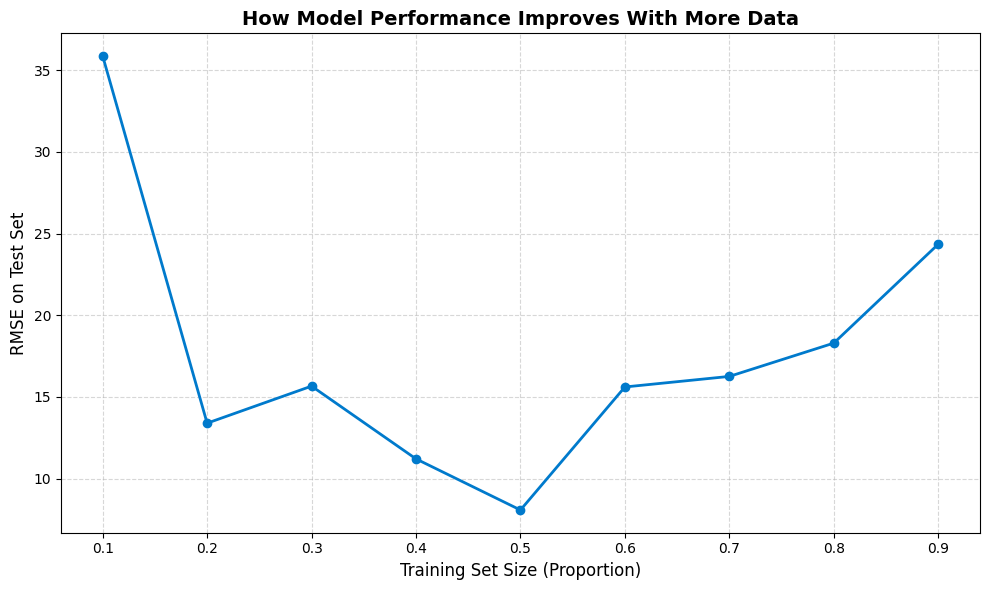

In [62]:
# 1. Load the CKD dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load dataset
ckd_path = "/mnt/data/ckd_dataset_v2.csv"  # If running locally, update this path
df = pd.read_csv("ckd_dataset_v2.csv")

# 2. Clean 'grf' column and prepare features
df['grf_cleaned'] = df['grf'].astype(str).str.replace('[^0-9.]', '', regex=True)
df['grf_cleaned'] = pd.to_numeric(df['grf_cleaned'], errors='coerce')
df_cleaned = df.dropna(subset=['grf_cleaned'])

X = df_cleaned.drop(columns=['grf', 'grf_cleaned'])
y = df_cleaned['grf_cleaned']
X = pd.get_dummies(X, drop_first=True)

# 3. Train Random Forest across training sizes and collect RMSE
rmse_list = []
train_sizes = np.linspace(0.1, 0.9, 9)

for size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # manually compute RMSE
    rmse_list.append(rmse)

# 4. Plot SWD-style graph
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, rmse_list, marker='o', linewidth=2, color='#007ACC')
plt.title("How Model Performance Improves With More Data", fontsize=14, fontweight='bold')
plt.xlabel("Training Set Size (Proportion)", fontsize=12)
plt.ylabel("RMSE on Test Set", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(train_sizes.round(2))
plt.tight_layout()
plt.show()


#  Storytelling With Data Reproduction – Chapter 6 

I created this line chart as a reproduction of an idea from Chapter 6 of the book Storytelling With Data.

Here’s the original image from the book: 

The chart I created follows this basic concept. You can see that as the training set size increases, so does the performance of the model, according to RMSE. The improvement is good and expected, but the curve is leveling off, which means more data is going to have a limited benefit after a certain point.

It’s a very simple chart with a clear story. The point of this chart is further reinforced by the idea of high-quality and high-volume data in healthcare machine learning. We need the right datasets if we want to effectively use ML to predict outcomes for patients such as GFR in chronic kidney disease.